In [1]:
import os
os.chdir("../..")

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
# from src.utils.echo_utils import get2dPucks ### We are using a debugging version!!
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
%matplotlib widget
from src.strain import *

# for get2dpucks
from skimage.transform import (resize, 
                               rescale)
from skimage.segmentation import find_boundaries

In [4]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [5]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 13.52it/s]


In [6]:
model_save_path = "save_models/Original_Pretrained_R2plus1DMotionSegNet.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


In [7]:
test_pat_index = 55

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

In [8]:
# let's try to use 9 pucks, if we divide into N=3 sections, we define each section to be 3 pucks
def get2dPucks(abin, apix, npucks=9, vis=False, debug=False):
    '''
    get2dPucks(abin, apix): Return the linear extent of the binary structure,
    as well as a sequence of radii about that extent.
    '''
    
    all_puck_endpoints = []
    
    
    # Empty bin?
    if ~np.any(abin):
        return 1.0, np.zeros((npucks,))
    
    x,y = np.where(abin>0)
    X = np.stack([x,y]) # Coords of all non-zero pixels., 2 x N
    if X.shape[1] < 1: # no pixels, doesn't seem to be a problem usually. 
        return (0.0, np.zeros((npucks,)))
    # Scale dimensions
    X = np.multiply(X, np.array(apix)[:, None]) # Need a broadcastable shape, here 2 x 1
    try:
        val, vec = np.linalg.eig(np.cov(X, rowvar=True))
    except:
        return (0.0, np.zeros((npucks,)))
    
    # Make sure we're in decreasing order of importance.
    eigorder = np.argsort(val)[-1::-1]
    vec = vec[:, eigorder]
    val = val[eigorder]
    
    if debug:
        print(f'eigorder: {eigorder}')
        print(f'vec: {vec}')
        print(f'val: {val}')
    
    # Negate the eigenvectors for consistency. Let's say y should be positive eig0,
    # and x should be positive for eig1. I'm not sure if that's what I'm doing here,
    # but just trying to be consistent.
    if vec[0,0] < 0:
        vec[:,0] = -1.0*vec[:,0]
    if vec[1,1] < 0:
        vec[:,1] = -1.0*vec[:,1]
    
    if debug:
        print('negated eigenvectors for consistency')
        print(f'vec: {vec}')
    
    mu = np.expand_dims(np.mean(X, axis=1), axis=1)
    
    if debug:
        print(f'mu: {mu}')
    
    # Now mu is 2 x 1 mean pixel coord 
    # val is eigenvalues, vec is 2 x 2 right eigvectors (by column), all in matrix ij format
    
    # Use the boundary to get the radii.
    # Project the boundary pixel coords into the eigenspace.
    B = find_boundaries(abin, mode='thick')
    Xb = np.stack(np.where(B))
    Xb = np.multiply(Xb, np.array(apix)[:, None]) # space coords again.
    proj = np.dot((Xb-mu).T,vec) 
    # proj is M x 2, the projections onto 0 and 1 eigs of the M boundary coords.
    
    if debug:
        print(f'B: {B}')
        print(f'Xb: {Xb}')
        print(f'proj: {proj}')
    
    
    # Now get min max in the first principal direction. That's L! Just L[0] here.
    L_min, L_max = np.min(proj, axis=0), np.max(proj, axis=0)
    L = L_max - L_min
    
    if debug:
        print(f'L_min: {L_min}')
        print(f'L_max: {L_max}')
        print(f'L: {L}')
    
    # Partition along the principal axis. The secondary axis represents the radii.
    L_partition = np.linspace(L_min[0], L_max[0], npucks+1)
    
    if debug:
        print(f'L_partition: {L_partition}')
    
    R = []
    A = np.copy(proj)
    for i in range(len(L_partition)-1):
        # Select those boundary points whose projection on the major axis
        # is within the thresholds. 
        which = np.logical_and(A[:,0] >= L_partition[i],
                               A[:,0] < L_partition[i+1])
        # here which could be empty, if there are multiple components to the binary,
        # which will happen without cleaning for the largest connected component and 
        # such. r will be nan, here I replace with zero.
        # In fact, this math really only works well with nice convex objects.
        if len(which) == 0:
            r = 0
        else:
            r = np.median(np.abs(A[:,1][which]))
        R.append(r)
    
    if debug:
        print(f'R: {R}')
        print(f'A: {A}')

        print('return vals:')
        print(f'L[0]: {L[0]}')
        print(f'np.array(R): {np.array(R)}')

    
    if vis:
        # Some visualization code I didn't know where else to put!
        # B is still in image coords, while mu and the vec and L's are in mm? Use extent.
        # extent = (-0.5, apix[1]*B.shape[1]-0.5, -0.5, apix[0]*B.shape[0]-0.5)# (left, right, bottom, top)
        
        # This got me pretty confused. The issue is that if apix is something other than (1,1), then 
        # B needs to be scaled accordingly. 
        # If apix is significantly less than 1,1, then the 0 order and no anti-aliasing could
        # leave little of the boundary left. Though it would only affect the vis, as the calculation
        # above scaled the boundary points to double, instead of this which returns pixels.
        abin_scaled = rescale(abin, apix, order=0, 
                              preserve_range=True, 
                              anti_aliasing=False, 
                              multichannel=False)
        Bscaled = find_boundaries(abin_scaled, mode='thick')
        
        if debug:
            print(f'abin_scaled: {abin_scaled}')
            print(f'Bscaled: {Bscaled}')
        
        plt.figure(figsize=(5,5))
        plt.imshow(Bscaled) # , origin='upper', extent=extent)
        
        plt.gca().set_aspect('equal')
        plt.axis('equal')
        

        # Plot the mean and principal projections. But plot needs xy (euclid) instead of ij (matrix)!!!
        # Stupid, keeping the sliced out dimension with None here.
        pca0 = np.array([mu + L_min[0]*vec[:,0, None], mu + L_max[0]*vec[:,0, None]])
        pca1 = np.array([mu + L_min[1]*vec[:,1, None], mu + L_max[1]*vec[:,1, None]])
        
        if debug:
            print(f'pca0: {pca0}')
            print(f'pca1: {pca1}')

        # Notice the x and y coord reversed. 
        
        # these are only the end points of the major and minor axes I think ? 
        # plt.scatter(x=mu[1], y=mu[0], s=30, marker='*') # what is this one? ?? -- hard to tell, no visual difference?
        plt.scatter(x=pca0[:,1], y=pca0[:,0], c = [[.2, .4, .2], [.6, .9, .6]]) # Dark green to light green (top to bottom of the major axis)
        plt.scatter(x=pca1[:,1], y=pca1[:,0], c = [[.4, .2, .2], [.9, .6, .6]]) # Dark red to light red (left to right of the minor axis)
        
        if debug:
            print('scatter 1:')
            print(f'x={mu[1]}, y={mu[0]}, s=30, marker=\'*\'')
            print('scatter 2:')
            print(f'x={pca0[:,1]}, y={pca0[:,0]}, c = [[.2, .4, .2], [.6, .9, .6]]')
            print(f'scatter 3:')
            print(f'x={pca1[:,1]}, y={pca1[:,0]}, c = [[.4, .2, .2], [.9, .6, .6]]')

        # these are lines of the actual major and minor axes
        plt.plot(pca0[:,1], pca0[:,0], 'g--') # major axis (top to bottom)
        plt.plot(pca1[:,1], pca1[:,0], 'r--') # minor axis (left to right)
        
        if debug:
            print(f'plot 1:')
            print(f'{pca0[:,1]}, {pca0[:,0]}, \'g--\'')

            print(f'plot 2:')
            print(f'pca1[:,1], pca1[:,0], \'r--\'')

        if debug:
            print('for loop looping over range ( len(L_partition) - 1)')
            
            
        # this plots all of the points of the individual lines of the npucks 
        for i in range(len(L_partition)-1):
            
            extent = (L_partition[i]+L_partition[i+1])/2
            points = np.array([mu + extent*vec[:,0, None] - R[i]*vec[:,1, None], # negative radius
                               mu + extent*vec[:,0, None] + R[i]*vec[:,1, None]]) # positive radius
            
            
            plt.plot(points[:,1], points[:,0])
            
            all_puck_endpoints.append(np.transpose(points))
            
            
            # print(f'i: {i}\npoints: {points}')
            # print(f'points[:,1], points[:,0]: {points[:,1], points[:,0]}')
            
            if debug:
                print(f'i={i}')
                print(f'extent: {extent}')
                print(f'points: {points}')
                print(f'plot with ({points[:,1]} , {points[:,0]})')
            
            
        
        plt.gca().set_aspect('equal')
        plt.axis('equal')
#         plt.axis('square')

        # title 2d area and approximation.
        plt.suptitle('Actual scaled area {:.2f}, approx {:.2f}'.format(np.prod(apix)*abin.sum(), 
                                                                       (L[0]/npucks)*2*np.sum(R)))
#         plt.tight_layout()
    
    return L[0], np.array(R), np.array(all_puck_endpoints)

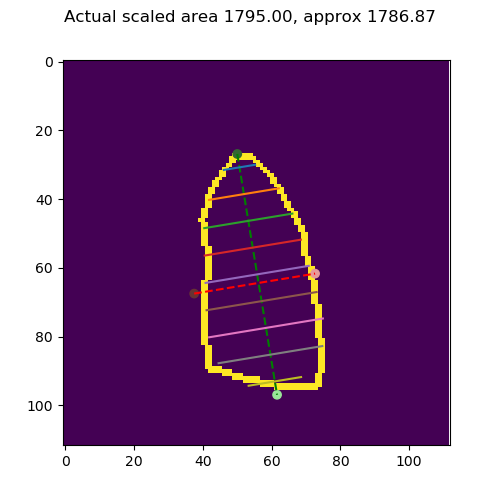

In [9]:
I = ed_label

length_I, radius_I, points_I = get2dPucks((I == 1).astype('int'), (1.0, 1.0), vis=True, debug=False)

I = give_boundary_no_basal_plane(ed_label)

In [10]:
length_I, radius_I, points_I.shape

(71.0028454560969,
 array([ 4.60282279, 10.27377881, 12.98911437, 14.1711838 , 15.2068915 ,
        16.22136337, 16.76408883, 15.28840218,  7.72995894]),
 (9, 1, 2, 2))

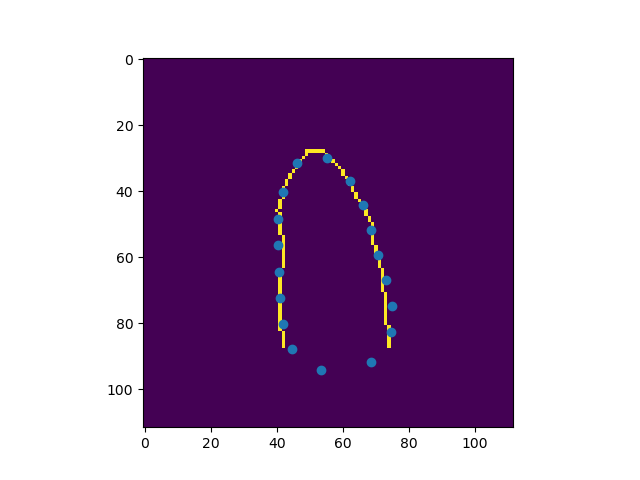

In [11]:
plt.figure()
plt.imshow(I)
plt.scatter(points_I[:, 0, 1], points_I[:, 0, 0])

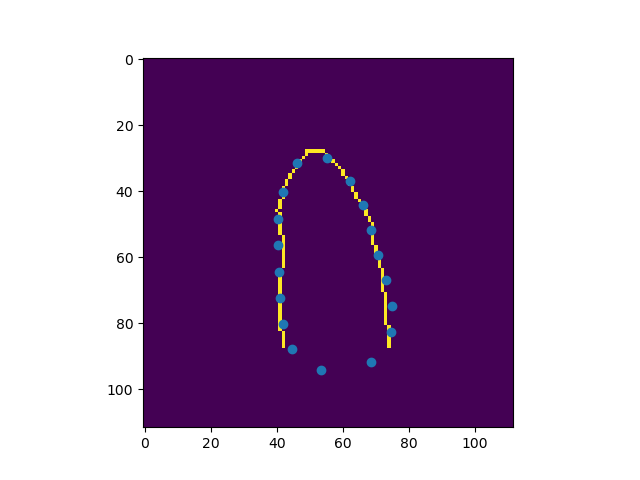

In [12]:
plt.figure()
plt.imshow(I)
plt.scatter(points_I[:, 0, 1], points_I[:, 0, 0])

In [13]:
N = 3
indeces_for_slice_points = []
for i in range(len(points_I)-1, 0, -N):
    indeces_for_slice_points.append(i)
indeces_for_slice_points.sort()
indeces_for_slice_points

[2, 5, 8]

In [14]:
slice_points = []

for i in indeces_for_slice_points:
    slice_points.append(points_I[i, 0, ...])
    
slice_points = np.array(slice_points)

In [15]:
print(slice_points)
slice_points.shape

[[[48.41488607 44.17987968]
  [40.37906493 66.00977091]]

 [[72.29281427 67.00395657]
  [41.04838221 73.05710763]]

 [[94.25953644 91.73923948]
  [53.28452022 68.53762364]]]


(3, 2, 2)

In [16]:
x,y = slice_points[0][0][0], slice_points[0][1][0]
print(x,y)

48.41488607110273 40.37906492729051


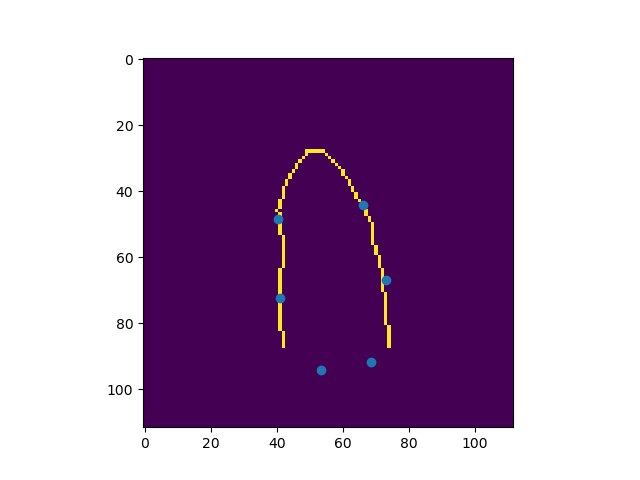

In [17]:
plt.figure()
plt.imshow(I)
plt.scatter(slice_points[:, 1], slice_points[:, 0]) # plot in x,y --- stored in i,j

In [18]:
slice_points, slice_points.shape

(array([[[48.41488607, 44.17987968],
         [40.37906493, 66.00977091]],
 
        [[72.29281427, 67.00395657],
         [41.04838221, 73.05710763]],
 
        [[94.25953644, 91.73923948],
         [53.28452022, 68.53762364]]]),
 (3, 2, 2))

In [19]:
slice_points[0]

array([[48.41488607, 44.17987968],
       [40.37906493, 66.00977091]])

In [20]:
# note that it is not (i,j) that is being stored! it is (i_0, i_1) lol....
# let's re-store it in another variable that's more intuitive

divide_points = [] # (i,j)
divide_points_i_vals = [] # i
divide_points_j_vals = [] # j

for a in slice_points:
    divide_points.append([ [a[0][0], a[1][0]] , [a[0][1], a[1][1]] ])
    divide_points_i_vals.append(a[0][0])
    divide_points_i_vals.append(a[0][1])
    divide_points_j_vals.append(a[1][0])
    divide_points_j_vals.append(a[1][1])

divide_points = np.array(divide_points)

In [21]:
divide_points.shape, divide_points # ( (i,j), (i,j) ) ..

((3, 2, 2),
 array([[[48.41488607, 40.37906493],
         [44.17987968, 66.00977091]],
 
        [[72.29281427, 41.04838221],
         [67.00395657, 73.05710763]],
 
        [[94.25953644, 53.28452022],
         [91.73923948, 68.53762364]]]))

In [22]:
# need to transform the image pixels into a set of points (i,j)
I_point_set = []
I_point_set_i_vals = []
I_point_set_j_vals = []

for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        if I[i][j] == 1:
            I_point_set.append([i,j])
            I_point_set_i_vals.append(i)
            I_point_set_j_vals.append(j)

I_point_set = np.array(I_point_set)

In [23]:
I_point_set.shape, np.count_nonzero(I == 1) # count should match

((124, 2), 124)

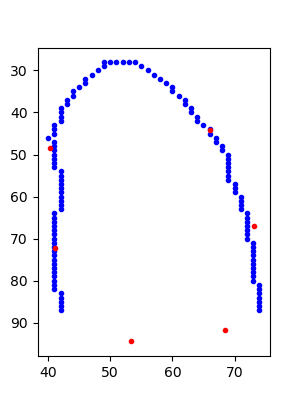

In [24]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
ax.scatter(I_point_set_j_vals, I_point_set_i_vals, marker='.', color='b', zorder=1)
ax.scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=2)
ax.invert_yaxis()

Now we need to check whether the set of points representing the lv is above or below the imaginary line drawn by each pair of slice points. We can do this by checking the sign value of taking the determinant of this matrix: 
$$\begin{bmatrix} x_2 - x_1 & x_3 - x_1 \\ y_2 - y_1 & y_3 - y_1 \end{bmatrix} $$
where $(x_1, y_1)$ and $(x_2, y_2)$ are the pair of points representing the imaginary line between them and $(x_3, y_3)$ represents the point to be checked. 

- $> 0 $ then above line
- $< 0 $ then below line
- $= 0 $ then on line

This is taken from this [stackoverflow](https://stackoverflow.com/a/3461499/19266332).

## The whole point of using the 2d pucks is to slice it NOT horizontally.
## we want to slice it slanted however much the minor axis is angled

In [25]:
def is_point_above_below_line(p1, p2, p3):
    '''
    input: p1, p2, p3 -- iterables containing (x,y)
        p1 and p2 represent line and p3 is point to be checked
        note that this is supposed to be in euclidean space (x,y) 
        if points are in (i,j) please convert them first into (x,y)
        x = j, y = i
    output:
        +1 for above line
        -1 for below line
        0 for on the line
    '''
    a = (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
    if a > 0:
        return 1
    elif a < 0:
        return -1
    else:
        return 0

In [26]:
def ij_to_xy(p):
    '''
    input: p - (i,j)
    output: p - (x,y)
    x = j, y = i
    '''
    return np.array([p[1], p[0]])

In [27]:
divide_points[0][0], divide_points[0][1], ij_to_xy(divide_points[0][0])

(array([48.41488607, 40.37906493]),
 array([44.17987968, 66.00977091]),
 array([40.37906493, 48.41488607]))

In [28]:
# get top points

I_top_points = []
p1 = ij_to_xy(divide_points[0][0])
p2 = ij_to_xy(divide_points[0][1])

for point in I_point_set:
    # print(point)
    p3 = ij_to_xy(point)

    foo = is_point_above_below_line(p1, p2, p3)
    
    # only want points BELOW this line for the top region
    # store coords as ij
    # want below the line because we flipped the yaxis for viewing.... sigh
    if foo == -1:
        I_top_points.append(point)
        
I_top_points = np.array(I_top_points)

In [29]:
I_top_points.shape

(42, 2)

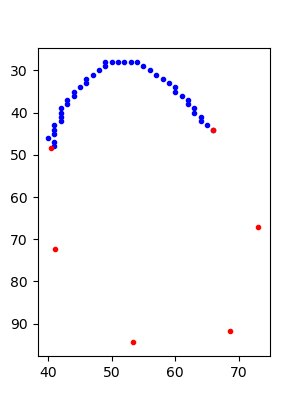

In [30]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
ax.scatter(I_top_points[:, 1], I_top_points[:, 0], marker='.', color='b', zorder=2)
ax.scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax.invert_yaxis()

In [31]:
I_regional_point_sets = [0 for i in range(N)]

# divide_points = np.insert(divide_points, 0, np.array([ [0,0] , [I.shape[1] - 1, 0] ]), axis=0) # inserting coordinates in (i,j) format


In [32]:
I_regional_point_sets

[0, 0, 0]

In [33]:
divide_points

array([[[48.41488607, 40.37906493],
        [44.17987968, 66.00977091]],

       [[72.29281427, 41.04838221],
        [67.00395657, 73.05710763]],

       [[94.25953644, 53.28452022],
        [91.73923948, 68.53762364]]])

In [40]:
# let's try to get all of the regions automatically
# we'll want to do some kind of "inbetween two lines" -- a combination of above this line and below this line.

# first insert a pair of coordinates at the edges of the image

N = 3

for i in range(N):
    curr_region_point_set = []
    tmp_point_count = 0
    
    # first region
    if i == 0:
        p1 = ij_to_xy(divide_points[i][0])
        p2 = ij_to_xy(divide_points[i][1])
        
        for point in I_point_set:
            p3 = ij_to_xy(point)
        
            if is_point_above_below_line(p1, p2, p3) == -1:
                curr_region_point_set.append(point)
                tmp_point_count += 1
                
        print(f'points in region i={i}: {tmp_point_count}')
        print(f'{p1} {p2}')
        
    # 2nd and + regions
    else:
        start_p1 = ij_to_xy(divide_points[i-1][0])
        start_p2 = ij_to_xy(divide_points[i-1][1])

        end_p1 = ij_to_xy(divide_points[i][0])
        end_p2 = ij_to_xy(divide_points[i][1])

        # look at the entire point set representing the entire lv
        for point in I_point_set:
            p3 = ij_to_xy(point)

            check_1 = is_point_above_below_line(start_p1, start_p2, p3)
            check_2 = is_point_above_below_line(end_p1, end_p2, p3)

            # print(check_1, check_2)

            # above the first line and below the second line
            # save point in (i,j) format
            if check_1 == 1 and check_2 == -1:
                curr_region_point_set.append(point)
                tmp_point_count += 1

        print(f'points in region i={i}: {tmp_point_count}')
        print(f'{start_p1} {start_p2} | {end_p1} {end_p2}')
    
    # save curr region point set
    I_regional_point_sets[i] = np.array(curr_region_point_set)
    
I_regional_point_sets = np.array(I_regional_point_sets)

points in region i=0: 42
[40.37906493 48.41488607] [66.00977091 44.17987968]
points in region i=1: 47
[40.37906493 48.41488607] [66.00977091 44.17987968] | [41.04838221 72.29281427] [73.05710763 67.00395657]
points in region i=2: 35
[41.04838221 72.29281427] [73.05710763 67.00395657] | [53.28452022 94.25953644] [68.53762364 91.73923948]


In [41]:
# divide_points_j_vals.append(0)
# divide_points_i_vals.append(0)

# divide_points_j_vals.append(112)
# divide_points_i_vals.append(0)

In [42]:
I_regional_point_sets.shape, I_regional_point_sets

((3,),
 array([array([[28, 49],
        [28, 50],
        [28, 51],
        [28, 52],
        [28, 53],
        [28, 54],
        [29, 49],
        [29, 55],
        [30, 48],
        [30, 56],
        [31, 47],
        [31, 57],
        [32, 46],
        [32, 58],
        [33, 46],
        [33, 59],
        [34, 45],
        [34, 60],
        [35, 44],
        [35, 60],
        [36, 44],
        [36, 61],
        [37, 43],
        [37, 62],
        [38, 43],
        [38, 62],
        [39, 42],
        [39, 63],
        [40, 42],
        [40, 63],
        [41, 42],
        [41, 64],
        [42, 42],
        [42, 64],
        [43, 41],
        [43, 65],
        [44, 41],
        [44, 66],
        [45, 41],
        [46, 40],
        [47, 41],
        [48, 41]]),
        array([[45, 66],
        [46, 67],
        [47, 67],
        [48, 68],
        [49, 41],
        [49, 68],
        [50, 41],
        [50, 69],
        [51, 41],
        [51, 69],
        [52, 41],
        [52, 69],
     

In [43]:
I_regional_point_sets[0].shape, I_regional_point_sets[1].shape, I_regional_point_sets[2].shape

((42, 2), (47, 2), (35, 2))

In [44]:
divide_points.shape

(3, 2, 2)

In [45]:
divide_points

array([[[48.41488607, 40.37906493],
        [44.17987968, 66.00977091]],

       [[72.29281427, 41.04838221],
        [67.00395657, 73.05710763]],

       [[94.25953644, 53.28452022],
        [91.73923948, 68.53762364]]])

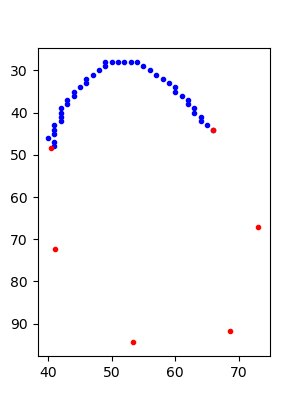

In [46]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
ax.scatter(I_regional_point_sets[0][:, 1], I_regional_point_sets[0][:, 0], marker='.', color='b', zorder=2)
ax.scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax.invert_yaxis()

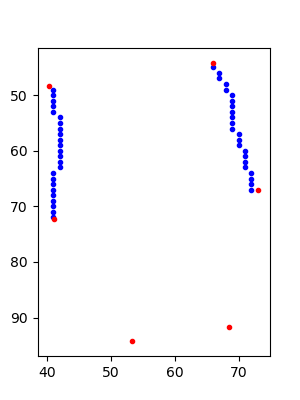

In [47]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
ax.scatter(I_regional_point_sets[1][:, 1], I_regional_point_sets[1][:, 0], marker='.', color='b', zorder=2)
ax.scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax.invert_yaxis()

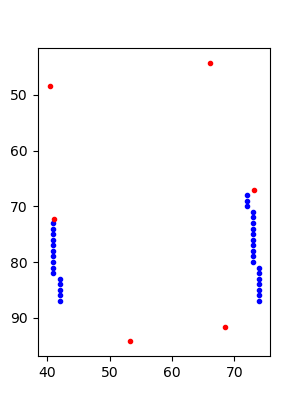

In [48]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
ax.scatter(I_regional_point_sets[2][:, 1], I_regional_point_sets[2][:, 0], marker='.', color='b', zorder=2)
ax.scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax.invert_yaxis()

In [ ]:
# # i think it would be easiest to just slice by taking the pixels in the section above the lowest of the pair of pixels for each radii line 
# # instead of somehow drawing a slanted line btwn the two points

# lower_points = []

# for i in range(slice_points.shape[0]):
#     x = slice_points[i]
#     i_1, i_2 = x[0][0], x[0][1]
#     if i_1 > i_2:
#         x = x[:, 0]
#     else:
#         x = x[:, 1]
#     lower_points.append(x)
# lower_points = np.array(lower_points)
# print(lower_points.shape)

In [ ]:
# lower_points

In [ ]:
# lower_points = lower_points.astype('int')
# lower_points

In [ ]:
# plt.figure()
# plt.imshow(give_boundary_no_basal_plane(ed_label))
# plt.scatter(lower_points[:, 1], lower_points[:, 0]) # plot in x,y --- stored in i,j

In [ ]:
# lower_points = np.insert(lower_points, 0, [0,0], axis=0)

# I = give_boundary_no_basal_plane(I)

# import copy

# I_regional_splits = [0 for i in range(N)]

# for i in range(N):
#     I_copy = copy.deepcopy(I)
    
#     start = lower_points[i][0]
#     end = lower_points[i+1][0]

#     I_copy[0:start, 0:I_copy.shape[1]] = 0
#     I_copy[end:I_copy.shape[0], 0:I_copy.shape[1]] = 0
    
#     I_regional_splits[i] = I_copy
    
#     vis_single(I_copy, cmap='gray')